# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)

It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits? 

In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.

Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:

In [1]:
#!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
#!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
#!pip install pymoo

In [2]:
import numpy as np
import pandas as pd
import pymoo
import copy
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('market.csv', index_col=0)
df.head()

,stock,weight,price_A,price_B,price_C
Apple,5,5,1.00,0.5,1.1
Apricot,65,3,0.50,0.2,0.6
Blueberry,5,3,0.50,0.3,1.2
Cactus Fruit,90,4,0.75,0.3,0.3
Cherry,15,4,0.80,0.4,1.1


In [4]:
stock = df['stock'].to_dict()
weight = df['weight'].to_dict()
price = df['price_A'].to_dict()

In [5]:
stock

{'Apple': 5,
 'Apricot': 65,
 'Blueberry': 5,
 'Cactus Fruit': 90,
 'Cherry': 15,
 'Cranberry': 75,
 'Grape': 70,
 'Melon': 75,
 'Orange': 40,
 'Peach': 55,
 'Pomegranate': 5,
 'Rhubarb': 70,
 'Starfruit': 5,
 'Strawberry': 20,
 'Amaranth': 20,
 'Artichoke': 65,
 'Beet': 30,
 'Bok Choy': 55,
 'Cauliflower': 70,
 'Corn': 90,
 'Eggplant': 95,
 'Garlic': 95,
 'Green Bean': 55,
 'Hops': 75,
 'Hot Pepper': 25,
 'Kale': 5,
 'Parsnip': 10,
 'Potato': 55,
 'Pumpkin': 30,
 'Radish': 50,
 'Red Cabbage': 55,
 'Tomato': 65,
 'Wheat': 75,
 'Yam': 50,
 'Blackberry': 70}

To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.

In [6]:
# Modifiable surtout si on veut retourner des valeurs négatives pour à quelle point la contrainte est brisée
def evaluate(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

You can try this with an example load generated randomly:

In [7]:
trial_load = {}
for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])
trial_load

{'Apple': 3,
 'Apricot': 1,
 'Blueberry': 2,
 'Cactus Fruit': 5,
 'Cherry': 11,
 'Cranberry': 56,
 'Grape': 24,
 'Melon': 12,
 'Orange': 25,
 'Peach': 32,
 'Pomegranate': 3,
 'Rhubarb': 29,
 'Starfruit': 2,
 'Strawberry': 9,
 'Amaranth': 2,
 'Artichoke': 49,
 'Beet': 18,
 'Bok Choy': 6,
 'Cauliflower': 64,
 'Corn': 56,
 'Eggplant': 26,
 'Garlic': 9,
 'Green Bean': 43,
 'Hops': 24,
 'Hot Pepper': 17,
 'Kale': 0,
 'Parsnip': 7,
 'Potato': 11,
 'Pumpkin': 0,
 'Radish': 7,
 'Red Cabbage': 44,
 'Tomato': 32,
 'Wheat': 48,
 'Yam': 25,
 'Blackberry': 34}

In [8]:
evaluate(trial_load, stock, weight, price)

669.3

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)

In [9]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)

In [10]:
from pymoo.core.problem import ElementwiseProblem
from typing import List

# Multi-Objective KnapSack Problem 
class MOKSP(ElementwiseProblem):
    
    def __init__(self, n_var: int, list_obj: List[int], max_weight: int=5000, verbose: bool=True):      
        # Check on inputs : n_var and list_obj
        assert 1 <= n_var <= df.shape[0], "Too many n_var, max is 35"
        for obj in list_obj:
            assert 1 <= obj <= 3, "Values in list_obj are not in [1, 2, 3]"
        
        self.n_var = n_var
        self.max_weight = max_weight
        self.df = df[:self.n_var]
        
        if verbose:
            print("Row count : ", df.shape[0])
            print(self.df)
        
        # lower bound
        xl = np.zeros(n_var)
        # upper bound
        xu = self.df['stock'].values
        
        self.price_keys = [x for x in df.columns.to_list() if "price" in x]
        
        
        self.stock = self.df['stock'].values
        self.weight = self.df['weight'].values
        self.price = []
        
        for obj in list_obj:
            self.price.append(self.df[self.price_keys[obj-1]].values)
        
        super().__init__(n_var=n_var, n_obj=len(list_obj), n_constr=1, xl=xl, xu=xu)
    
    def compute_price_and_weight(self, load):
        total_weight = 0
        total_price = np.zeros(len(self.price))
        for i in range(len(self.price)):
            for k in range(load.shape[0]):
                total_price[i] += load[k] * self.price[i][k]
                if i==0:
                    total_weight += load[k] * self.weight[k]
        return total_weight, total_price
    
    def _evaluate(self, x, out, *args, **kwargs):

        total_weight, fits = self.compute_price_and_weight(x)
        
        fits = -fits # The optimizer only works with minimization
        
        if total_weight > self.max_weight:
            c = total_weight - self.max_weight
            fits = 0.0*fits
        else:
            c = 0
        
        # return by modifying out
        out["F"] = fits
        out["G"] = c

In [11]:
problem = MOKSP(35, [1], 5000, verbose=False)
res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=False)

In [12]:
def print_end_results(problem, results):
    
    print("Training time : ", np.round(results.exec_time,3), "s")
    
    if len(results.X.shape) == 1:
        weight, score = problem.compute_price_and_weight(results.X)
        print("Best score : \t", score)
        print("Weight : \t", weight)
        print("Load breakdown : \n", results.X)

    else:
        print("Multiple solutions exist")
        weight, price = problem.compute_price_and_weight(results.X[0,:])
        best_mean_price = np.mean(price)
        best_mean_X = results.X[0,:]
        best_single_optim_X = []
        best_singel_optim_price = []
        for i in range(len(price)):
            best_single_optim_X.append(np.copy(results.X[0,:]))
            best_singel_optim_price.append(price[i])        
        
        for i in range(1, results.X.shape[0]):
            X = results.X[i,:]
            weight, price = problem.compute_price_and_weight(X)
            mean_price = np.mean(price)
            if mean_price > best_mean_price:
                best_mean_price = mean_price
                best_X = X
            for i in range(len(price)):
                if price[i] > best_singel_optim_price[i]:
                    best_singel_optim_price[i] = price[i]
                    best_single_optim_X[i] = np.copy(X)
        
        weight, price = problem.compute_price_and_weight(best_mean_X)
        print("Best mean score : ", np.mean(price), " Score detail : ", price)
        print("Weight : \t", weight)
        print("Load breakdown : \n", best_mean_X)
        
        for i in range(len(best_singel_optim_price)):
            X = best_single_optim_X[i]
            weight, price = problem.compute_price_and_weight(X)
            print("Best single score : ", price[i])
            print("Weight : \t", weight)
            print("Load breakdown : \n", X)
    
    print("\nIn stock : \n", problem.stock)  
    print("\n\n")

In [13]:
print_end_results(problem, res)
# Best so far 1142

Training time :  4.985 s
Best score : 	 [1127.5]
Weight : 	 4994
Load breakdown : 
 [ 5 63  1 90 14 74 63  0 16 44  4  0  0 20 20 62 30 55 70 89 94 95 48  0
 21  4 10 52  0 48 42 64  0 50 46]

In stock : 
 [ 5 65  5 90 15 75 70 75 40 55  5 70  5 20 20 65 30 55 70 90 95 95 55 75
 25  5 10 55 30 50 55 65 75 50 70]





In [14]:
def get_convergence(results):
    n_gen = np.array([e.evaluator.n_eval for e in results.history])/results.history[0].evaluator.n_eval
    score = -np.array([e.opt[0].F for e in results.history])
    
    if len(score[0]) > 1: # Multi-Optimization
        score = np.zeros((score.shape[0], score.shape[1]+1))
        
        for i in range(len(results.history)):
            e = results.history[i]
            for k in range(len(e.opt)):
                new = -e.opt[k].F
                for m in range(score.shape[1]):
                    if m == score.shape[1]-1:
                        if np.mean(new) > score[i,score.shape[1]-1]:
                            score[i,score.shape[1]-1] = np.mean(new)
                    else:
                        if new[m] > score[i,m]:
                            score[i,m] = new[m]
    return n_gen, score

        
        
def plot_convergence(n_gen, score, label: str=" "):
    
    plt.plot(n_gen, score, label=label)
    
    plt.title("Convergence")
    plt.xlabel("Generation")
    plt.ylabel("Total load price")
    plt.legend()
    plt.tight_layout

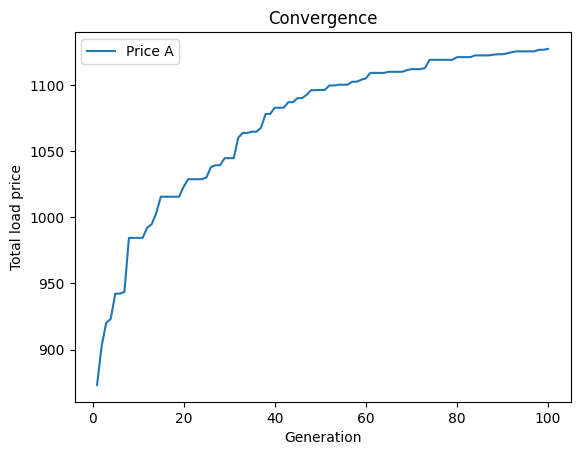

In [15]:
n_gen, score = get_convergence(res)
plot_convergence(n_gen, score, "Price A")

## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.

In [16]:
price_a = df['price_A'].to_dict()
price_b = df['price_B'].to_dict()
price_c = df['price_C'].to_dict()

In [17]:
price_a['Cherry'], price_b['Cherry'], price_c['Cherry']

(0.8, 0.4, 1.1)

Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:

In [18]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)

669.3 301.79999999999995 421.6


Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.

Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.

In [19]:
# Running same optimizer but with different objectives
problem_list = []
res_list = []

# List of objectives to optimize on
obj_list_list = [[1], [2], [3], [1, 2, 3]] # 1=Price A, 2=Price B, 3=Price C

for obj_list in obj_list_list:
    print("Optimizing on objective(s) :", obj_list)
    
    problem_list.append(MOKSP(35, obj_list, 5000, verbose=False))
    res_list.append(
        minimize(problem_list[-1],
        algorithm,
        ("n_gen", 1000),
        seed=1,
        save_history=True,
        verbose=False)
    )

Optimizing on objective(s) : [1]
Optimizing on objective(s) : [2]
Optimizing on objective(s) : [3]
Optimizing on objective(s) : [1, 2, 3]


[1140.15]
[460.8]
[764.8]
[1112.15  445.5   731.3   743.05]


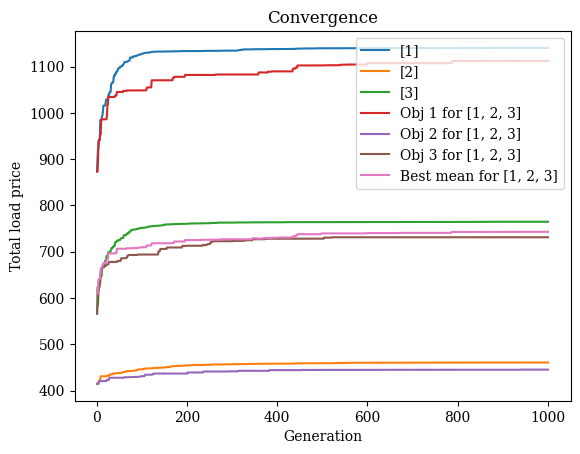

In [35]:
for i in range(len(obj_list_list)):
    n_gen, score = get_convergence(res_list[i])
    print(score[-1,:])
    
    if len(obj_list_list[i]) > 1:
        for j in range(score.shape[1]):
            if j == score.shape[1]-1:
                plot_convergence(n_gen, score[:,j], "Best mean for " + str(obj_list_list[i]))
            else:
                plot_convergence(n_gen, score[:,j], "Obj " + str(obj_list_list[i][j]) + " for " + str(obj_list_list[i]))
    else:
        plot_convergence(n_gen, score, str(obj_list_list[i]))

One can clearly see that optimizing on one objective is better that taking the best solution out of a multi-objective optimization. Knowing this, an optimization on the averaged price $Price_{avg} = \frac{Price_A + Price_B + Price_C}{3}$ should yield a better result than our current "Best mean for [1, 2, 3]".

Now we will fetch the resulting loads :

In [32]:
for i in range(len(obj_list_list)):
    print("Optimization for : ", obj_list_list[i])
    print_end_results(problem_list[i], res_list[i])

Optimization for :  [1]
Training time :  48.62 s
Multiple solutions exist
Best mean score :  1140.15  Score detail :  [1140.15]
Weight : 	 5000
Load breakdown : 
 [ 5 23  0 90 15 75 70  0 40 45  2  0  0 20 20 65 30 55 70 90 95 95 55  0
 25  5 10 55  0 50 31 65  0 50 70]
Best single score :  1140.15
Weight : 	 5000
Load breakdown : 
 [ 5 23  0 90 15 75 70  0 40 45  2  0  0 20 20 65 30 55 70 90 95 95 55  0
 25  5 10 55  0 50 31 65  0 50 70]

In stock : 
 [ 5 65  5 90 15 75 70 75 40 55  5 70  5 20 20 65 30 55 70 90 95 95 55 75
 25  5 10 55 30 50 55 65 75 50 70]



Optimization for :  [2]
Training time :  47.167 s
Multiple solutions exist
Best mean score :  460.8  Score detail :  [460.8]
Weight : 	 5000
Load breakdown : 
 [ 5  0  5 30 15  0  0 75 40 44  5 70  0 20 20 36 30  1 70  0  0  0  0  4
 25  5 10  0 30 50 31  0  1 50  0]
Best single score :  460.8
Weight : 	 5000
Load breakdown : 
 [ 5  0  5 30 15  0  0 75 40 44  5 70  0 20 20 36 30  1 70  0  0  0  0  4
 25  5 10  0 30 50 31  0  1 5

Not only single objective optimization yields better performances, it is also faster to execute.

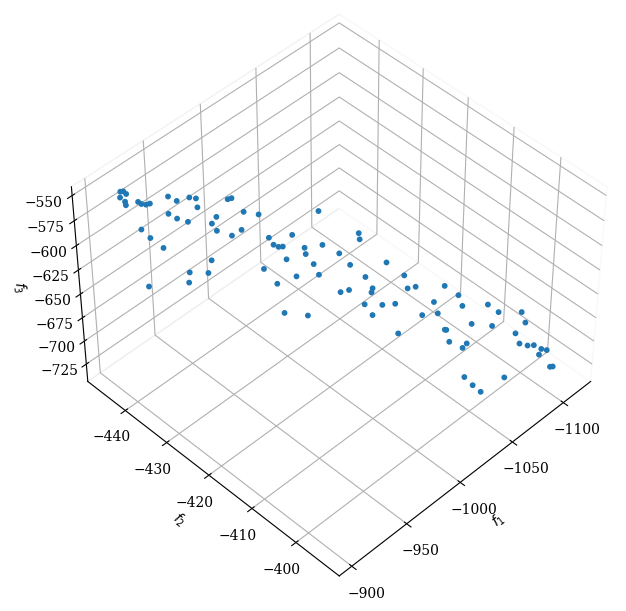

In [22]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(res_list[-1].F, s=10)
plot.show()

## Challenge 3

You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.

In [23]:
recipes = {'Ratatouille': {'Eggplant': 2, 'Garlic': 2, 'Tomato': 4, 'Hot Pepper': 1},
 'Apple Pie': {'Apple': 10, 'Wheat': 5},
 'Apricot Pie': {'Apricot': 10, 'Wheat': 5},
 'Cherry Pie': {'Cherry': 10, 'Wheat': 5},
 'Rhubarb Pie': {'Rhubarb': 10, 'Wheat': 5},
 'Strawberry Pie': {'Strawberry': 10, 'Wheat': 5},
 'Blackberry Pie': {'Blackberry': 10, 'Wheat': 5},
 'Pumpkin Pie': {'Pumpkin': 10, 'Wheat': 5},
 'Pizza': {'Tomato': 3, 'Wheat': 2, 'Artichoke': 1},
 'Baba Ghanoush': {'Eggplant': 2, 'Garlic': 4},
 'Squash Soup': {'Yam': 3, 'Pumpkin': 1},
 'Peach Beer': {'Hops': 3, 'Peach': 1},
 'Blackberry Beer': {'Hops': 3, 'Blackberry': 1}}

These recipes sell for good prices at each of the resellers:

In [24]:
dfr = pd.read_csv('recipes.csv', index_col=0)
dfr.head()

,price_A,price_B,price_C
Ratatouille,68.0,13.0,52.0
Apple Pie,146.0,84.0,176.0
Apricot Pie,81.0,46.0,110.0
Cherry Pie,120.0,72.0,176.0
Rhubarb Pie,133.0,162.0,98.0


In [25]:
price_a.update(dfr['price_A'].to_dict())
price_b.update(dfr['price_B'].to_dict())
price_c.update(dfr['price_C'].to_dict())
price_a['Apple Pie'], price_b['Apple Pie'], price_c['Apple Pie']

(146.0, 84.0, 176.0)

Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:

In [26]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load

{'Ratatouille': 0,
 'Apple Pie': 2,
 'Apricot Pie': 2,
 'Cherry Pie': 4,
 'Rhubarb Pie': 3,
 'Strawberry Pie': 3,
 'Blackberry Pie': 3,
 'Pumpkin Pie': 0,
 'Pizza': 4,
 'Baba Ghanoush': 0,
 'Squash Soup': 2,
 'Peach Beer': 2,
 'Blackberry Beer': 0}

In [27]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight

In [28]:
get_weight(recipe_load, recipes, weight)

1418

Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.

## Evaluation

You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

Criterion | Points
--- | ---
Results - Challenge 1 | 7
Results - Challenge 2 | 5
Results - Challenge 3 | 3
Presentation (code, text) | 5